# Direct Solve for Implicit Diffusion

We'll solve the linear system resulting from our implicit discretization
directly:

$$
\left (
\begin{array}{ccccccc}
1+\alpha &   -\alpha &           &        &         &           &          \\
-\alpha  & 1+2\alpha & -\alpha   &        &         &           &          \\
         & -\alpha   & 1+2\alpha & -\alpha&         &           &          \\
         &           & \ddots    & \ddots & \ddots  &           &          \\
         &           &           & \ddots & \ddots  & \ddots    &          \\
         &           &           &        & -\alpha & 1+2\alpha &-\alpha   \\
         &           &           &        &         & -\alpha   &1+\alpha \\
\end{array}
\right )
\left (
\begin{array}{c}
\phi_\mathrm{lo}^{n+1} \\
\phi_\mathrm{lo+1}^{n+1} \\
\phi_\mathrm{lo+2}^{n+1} \\
\vdots \\
\vdots \\
\phi_\mathrm{hi-1}^{n+1} \\
\phi_\mathrm{hi}^{n+1} \\
\end{array}
\right )
=
\left (
\begin{array}{c}
\phi_\mathrm{lo}^{n} \\
\phi_\mathrm{lo+1}^{n} \\
\phi_\mathrm{lo+2}^{n} \\
\vdots \\
\vdots \\
\phi_\mathrm{hi-1}^{n} \\
\phi_\mathrm{hi}^{n} \\
\end{array}
\right )
$$

we'll use the SciPy banded solver to do the linear algebra.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll use the same grid class and initial conditions as used with the explicit method.

In [2]:
class Grid:
    """ a simple class to hold cell-centered finite-difference  /
    finite-volume data """

    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = np.zeros((nx+2*ng), dtype=np.float64)

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the ghostcells with zero gradient (Neumann)
            boundary conditions """
        self.phi[0:self.ilo] = self.phi[self.ilo]
        self.phi[self.ihi+1:] = self.phi[self.ihi]

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))

In [3]:
def gaussian_ic(g, k, t=0.0, t0=1.e-4, phi1=1.0, phi2=2.0):
    xc = 0.5*(g.xmin + g.xmax)
    return (phi2 - phi1) * (np.sqrt(t0/(t + t0)) *
                            np.exp(-0.25 * (g.x - xc)**2 / (k * (t + t0)))) + phi1

## Implementation

Now, we have a few options for the linear algebra.  We can:

* Keep the matrix as sparse and only store the 3 diagonals that have nonzero elements.
  We can then use the SciPy [``solve_banded``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html) method to solve this.
  
* Construct the full dense matrix, including all the zeros.  Here, the SciPy
  [``sparse.diags``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.diags.html) method can
  be helpful.

We'll write a function to just do a single implicit solve of the system, with the intent that this will be called from the time-evolution loop.

In [4]:
from scipy import linalg

From the structure of our matrix, we have a main diagonal, $d$, and an upper ($u$) and lower ($l$) diagonal.  These have the form:

$${\bf d} = (1+\alpha, 1+2\alpha, 1+2\alpha, \ldots, 1+2\alpha, 1+\alpha)$$

$${\bf l} = (-\alpha, -\alpha, -\alpha, \ldots, -\alpha, 0)$$

$${\bf u} = (0, -\alpha, -\alpha, \ldots, -\alpha, -\alpha)$$

Where we keep $l$ and $u$ both to be length $N$, but insert a $0$ for the column where they are not defined.

For SciPy, we'll make a matrix that has 3 rows:

$${\bf A} = \left ( \begin{array}{c} {\bf u} \\ {\bf d} \\ {\bf l} \\ \end{array} \right )$$

This will be a $3\times N$ matrix.

In [5]:
def implicit_step(gr, phi, k, dt):
    """ diffuse phi implicitly through timestep dt """

    phinew = gr.scratch_array()

    alpha = k * dt / gr.dx**2

    # create the RHS of the matrix
    R = phi[gr.ilo:gr.ihi+1]

    # create the diagonal, d+1 and d-1 parts of the matrix
    d = (1.0 + 2.0*alpha)*np.ones(gr.nx)

    u = -alpha*np.ones(gr.nx)
    u[0] = 0.0

    l = -alpha*np.ones(gr.nx)
    l[-1] = 0.0

    # set the boundary conditions by changing the matrix elements

    # homogeneous neumann
    d[0] = 1.0 + alpha
    d[-1] = 1.0 + alpha

    # solve
    A = np.matrix([u, d, l])

    phinew[gr.ilo:gr.ihi+1] = linalg.solve_banded((1, 1), A, R)

    return phinew

Here's the main evolution loop.  It works in the same fashion as our explicit implementation.

In [6]:
def diffuse_implicit(nx, k, C, tmax, init_cond):
    """
    the main evolution loop.  Evolve

     phi_t = k phi_{xx}

    from t = 0 to tmax
    """

    # create the grid
    ng = 0
    
    g = Grid(nx, ng)

    # time info
    dt = C * 0.5 *g.dx**2 / k
    t = 0.0

    # initialize the data
    g.phi[:] = init_cond(g, k)

    while t < tmax:

        # make sure we end right at tmax
        if t + dt > tmax:
            dt = tmax - t

        # diffuse for dt
        phinew = implicit_step(g, g.phi, k, dt)

        g.phi[:] = phinew[:]
        t += dt

    return g

## Trends with timestep size

Now we can test it out.  Implicit methods are stable for all timesteps, but keep in mind that stability is not the same as accuracy.  Let's vary the timestep size to see what happens.

In [7]:
nx = 128

k = 1

t_diffuse = (1.0/nx)**2 / k

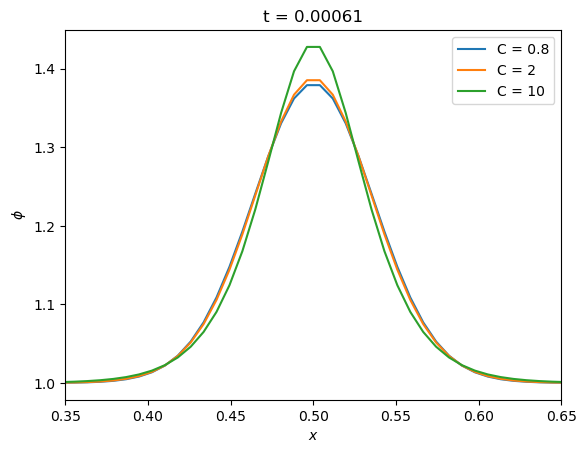

In [8]:
fig, ax = plt.subplots()

tmax = 10 * t_diffuse

for C in [0.8, 2, 10]:
    g = diffuse_implicit(nx, k, C, tmax, gaussian_ic)
    ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"C = {C}")

ax.set_xlim(0.35, 0.65)
ax.set_xlabel("$x$")
ax.set_ylabel("$\phi$")

ax.set_title(f"t = {tmax:7.3g}")
ax.legend()

We see that even at a large value of $C$, the solution remains stable.

## Convergence

Let's look at the convergence of this discretization

In [9]:
nx_reference = 64
t_diffuse = (1.0/nx_reference)**2 / k

Text(0, 0.5, 'absolute error')

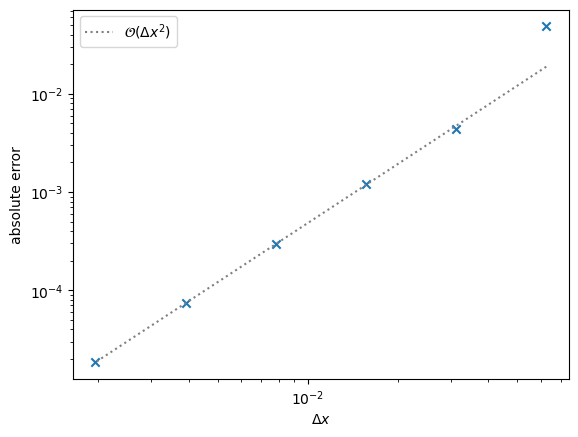

In [10]:
fig, ax = plt.subplots()

Ns = [16, 32, 64, 128, 256, 512]
dxs = []
errors = []

tmax = 10 * t_diffuse
C = 0.8

for nx in Ns:
    g = diffuse_implicit(nx, k, C, tmax, gaussian_ic)
    phi_analytic = gaussian_ic(g, k, t=tmax)
    dxs.append(g.dx)
    errors.append(g.norm(g.phi - phi_analytic))
    
ax.scatter(dxs, errors, marker="x")

ideal = errors[-1] * np.array(dxs)**2 / dxs[-1]**2

ax.plot(dxs, ideal, color="0.5", ls=":", label=r"$\mathcal{O}(\Delta x^2)$")

ax.legend()

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$\Delta x$")
ax.set_ylabel("absolute error")

We see second-order convergence, as with the explicit method.  The errors are _slightly_ higher
than the explicit discretion in general, but we do much better at coarse resolutions.